In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts


from mne_connectivity import spectral_connectivity_epochs
from mne.datasets import sample
import seaborn as sns

from scipy.signal import welch
import yasa
import constants
import numpy as np

#Let me see as many results as I want to see
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


### New Loading 

In [2]:
df_cols = ['Expt_type_num',  'Classifier', 'EEG Type','Power_Band', 'Accuracy', 'Accuracy_std']
df_dict = {}
for col in df_cols:
    df_dict[col] = []

power_bands = {'delta' : (0.5,4) , 'theta' : (4,8) , 'alpha' : (8,12) , 'sigma' : (12,16) , 'beta' : (16,30) , 'gamma' : (30,40) , 'all' : (0.5,40) }
power_band_names = [val for val in power_bands.keys()]

clf_names = ['Ada_B','DT', 'RF', 'SVM']
data_types = ['REM', 'N1', 'N2', 'N3', 'Wake']

In [3]:
load_path = '/user/home/ko20929/work/RBD_using_custom_package/Execute New Experiments/Connectivity/Connectivity_Results/Experiment_set_3/'

for data_type in data_types:
    for expt_num in [1,2,3,4]:
        f_name =  data_type + 'pli_expt_' + str(expt_num) + '_mean_std_' + 'raw_clfs_results.h5'
        res_df = pd.read_hdf(load_path + f_name)
        acc_std_df = run_expts.generate_subset_acc_std(res_df , return_df = True)
        means = acc_std_df.mean(axis = 0)
        for band in power_band_names + ['all_features']:
             for clf in clf_names:
                df_dict['Expt_type_num'].append(expt_num)
                df_dict['Classifier'].append(clf)
                df_dict['EEG Type'].append(data_type)
                df_dict['Power_Band'].append(band)
                df_dict['Accuracy'].append(means[band+'_'+clf+ '_acc'])
                df_dict['Accuracy_std'].append(means[band+'_'+clf+ '_std'])

results_df = pd.DataFrame(df_dict)

In [4]:
results_df

,Expt_type_num,Classifier,EEG Type,Power_Band,Accuracy,Accuracy_std
0,1,Ada_B,REM,delta,0.462500,0.157666
1,1,DT,REM,delta,0.475000,0.134124
2,1,RF,REM,delta,0.550000,0.193541
3,1,SVM,REM,delta,0.600000,0.152126
4,1,Ada_B,REM,theta,0.600000,0.089528
...,...,...,...,...,...,...
635,4,SVM,Wake,all,0.393939,0.146680
636,4,Ada_B,Wake,all_features,0.362879,0.169981
637,4,DT,Wake,all_features,0.312879,0.095192
638,4,RF,Wake,all_features,0.338636,0.130388


## Old loading

Things to save 
data_type , expt_number , power_band_features , classifier , Accuracy , Accuracy_std

In [18]:
expt_info = [ '1. PD vs HC', '2. (PD , PD+RBD) vs HC', '3. (PD + PD&RBD) vs HC vs RBD  multiclass', 
             '4. PD vs PD+RBD vs RBD vs HC  multiclass' ]

In [23]:
df_cols = ['Expt_type_num',  'Classifier', 'EEG Type','Power_Band', 'Accuracy', 'Accuracy_std']
df_dict = {}
for col in df_cols:
    df_dict[col] = []

power_bands = {'delta' : (0.5,4) , 'theta' : (4,8) , 'alpha' : (8,12) , 'sigma' : (12,16) , 'beta' : (16,30) , 'gamma' : (30,40) , 'all' : (0.5,40) }
power_band_names = [val for val in power_bands.keys()]

clf_names = ['Ada_B','DT', 'RF', 'SVM']

In [38]:
data_types = ['REM', 'N1', 'N2', 'N3', 'Wake']
load_path = '/user/home/ko20929/work/RBD_using_custom_package/Execute New Experiments/Connectivity/Connectivity_Results/Experiment_set_1/'

for data_type in data_types:
    for expt_num in [1,2,3,4]:
        f_name =  data_type + 'expt_' + str(expt_num) + '_' + 'raw_clfs_results.h5'
        res_df = pd.read_hdf(load_path + f_name)
        acc_std_df = run_expts.generate_subset_acc_std(res_df , return_df = True)
        means = acc_std_df.mean(axis = 0)
        for band in power_band_names + ['all_features']:
            for clf in clf_names:
                df_dict['Expt_type_num'].append(expt_num)
                df_dict['Classifier'].append(clf)
                df_dict['EEG Type'].append(data_type)
                df_dict['Power_Band'].append(band)
                df_dict['Accuracy'].append(means[band+'_'+clf+ '_acc'])
                df_dict['Accuracy_std'].append(means[band+'_'+clf+ '_std'])

results_df = pd.DataFrame(df_dict)

<Figure size 640x480 with 0 Axes>

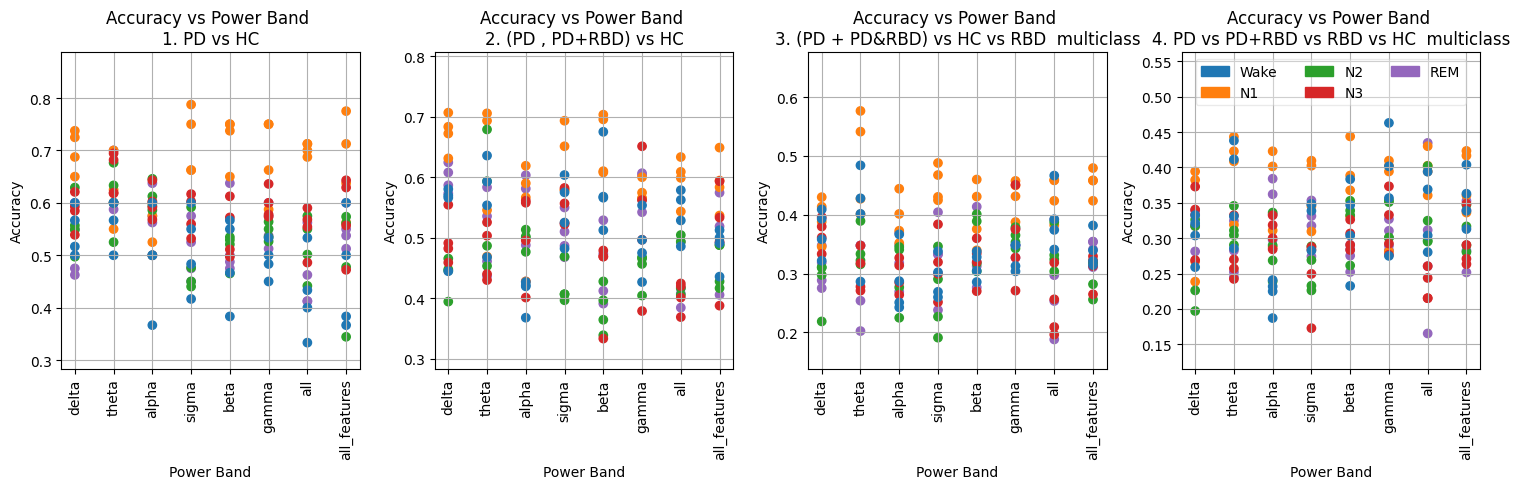

<Figure size 640x480 with 0 Axes>

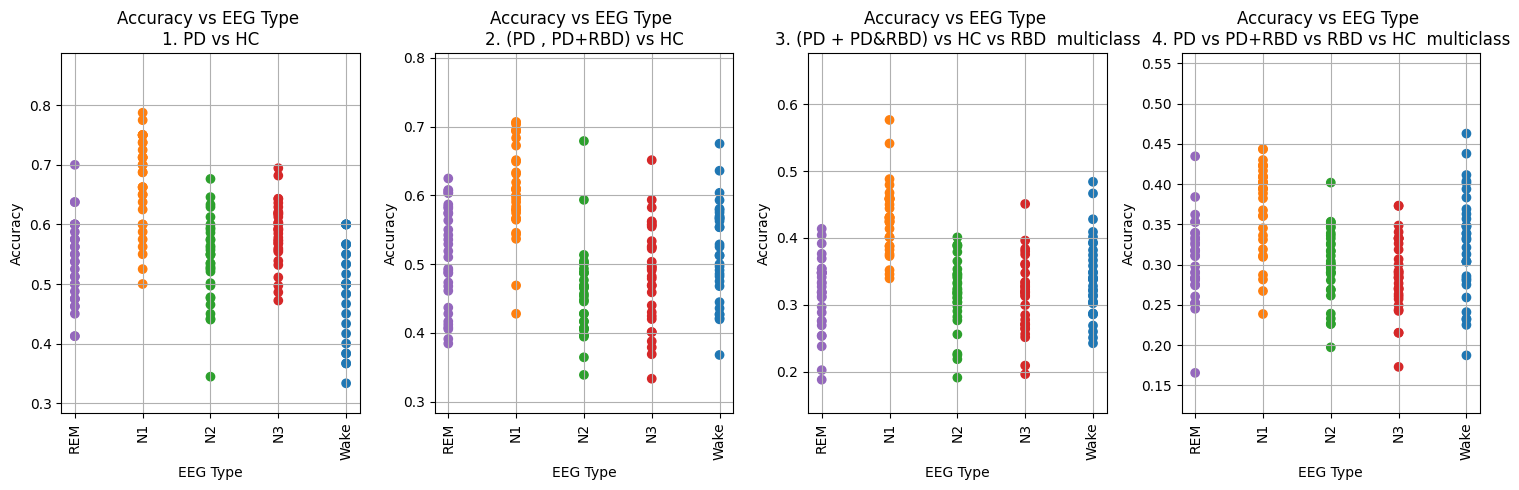

In [19]:
fig = plt.figure()
fig = plt.figure(figsize=(15,5),dpi=100)

for i in [1,2,3,4]:
    expt_num = i
    expt_results = results_df[results_df['Expt_type_num'] == expt_num].copy()
    expt_results.sort_values(by=['Power_Band','Accuracy'], ascending = False)
    
    ax = fig.add_subplot(1,4,i)
    
    plt.title('Accuracy vs Power Band \n' + expt_info[expt_num-1])
    
    #Define colours for the different data types
    colors = {'Wake':'tab:blue', 'N1':'tab:orange', 'N2':'tab:green', 'N3':'tab:red', 'REM':'tab:purple'}
    plt.scatter(expt_results['Power_Band'].values, expt_results['Accuracy'].values,
                    c = expt_results['EEG Type'].map(colors)) 
   
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.xlabel('Power Band')
    plt.ylabel('Accuracy')
    plt.ylim((expt_results['Accuracy'].min() - 0.05 , expt_results['Accuracy'].max() + 0.1))
    plt.grid()

    plt.tight_layout()

#Custom Legend, because standard legend wouldn't work for some reason
patches = []
for key, val in colors.items():
    patches.append(mpatches.Patch(color= val, label=key) )

# plt.legend(handles=patches, framealpha = 0.1)
plt.legend(loc = 'upper center', ncol = 3 ,  handles=patches, framealpha = 0.4)
    
plt.tight_layout()


#Do the plots again for data type accuracy distribution
fig = plt.figure()
fig = plt.figure(figsize=(15,5),dpi=100)

for i in [1,2,3,4]:
    expt_num = i
    expt_results = results_df[results_df['Expt_type_num'] == expt_num].copy()
    expt_results.sort_values(by=['Power_Band','Accuracy'], ascending = False)
    
    ax = fig.add_subplot(1,4,i)
    
    plt.title('Accuracy vs EEG Type \n' + expt_info[expt_num-1])
    
    #Define colours for the different data types
    colors = {'Wake':'tab:blue', 'N1':'tab:orange', 'N2':'tab:green', 'N3':'tab:red', 'REM':'tab:purple'}
    plt.scatter(expt_results['EEG Type'].values, expt_results['Accuracy'].values,
                    c = expt_results['EEG Type'].map(colors))

   
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.xlabel('EEG Type')
    plt.ylabel('Accuracy')
    plt.ylim((expt_results['Accuracy'].min() - 0.05 , expt_results['Accuracy'].max() + 0.1))
    plt.grid()

    plt.tight_layout()

plt.tight_layout()


# plt.savefig('classifier_accuracy_original_epoch_bpw.png', dpi=200) 